## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(labels.info())
print(len(labels))
print(labels['real_age'].median())
print(labels['real_age'].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
7591
29.0
31.20115926755368


In [4]:
print(labels[labels['real_age']<=5]['file_name'].count())

450


In [5]:
print(np.percentile(np.array(labels['real_age']), q = [5,95], axis = 0))

[ 5. 63.]


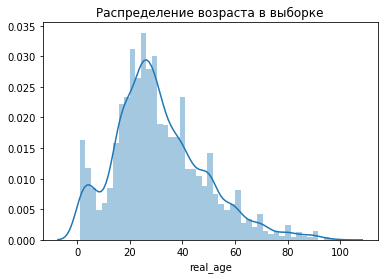

In [6]:
sns.distplot(labels['real_age'])
plt.title('Распределение возраста в выборке')
plt.show()

### Вывод
Как видно из гистограммы, распределение возрастов имеет смещение в левую сторону. Медианное значение возраста: 29, тогда как среднее 31. Помимо этого наблюдается большое кол-во детских фотографий, что выражено в пике до 5 лет. 90% датасета заключено в границах от 5 до 63 лет.
Для данной конкректной задачи - определение возраста клиента магазина,  большое кол-во детских фотографий является скорее недостатком, т.к. обычно чаще клиентами являются люди более старшего возраста, поэтому предсказания нейросети в реальных условиях могут быть искажены. Думаю, что такие факторы должны учитыватья при обучении моделей.

PS про аугментацию написано в общем выводе. Я хотел ее использовать, но решил сначала проверить значение mae без ее использования, но, оказывается, что тренажер не дает обучать нейросеть, если уже были достигнуты критерии для "сдачи" задания(mae < 8) :(

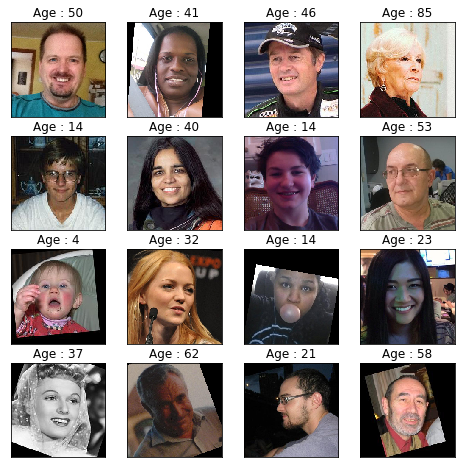

In [7]:
features,target = next(train_gen_flow)
it = 0
gridsize = (4, 4)
fig = plt.figure(figsize=(8, 8))
for i in range(0,4):
    for j in range(0,4):
        plt.subplot2grid(gridsize, (i, j))
        plt.imshow(features[it])
        plt.title('Age : {}'.format(target[it]))
        plt.xticks([])
        plt.yticks([])
        it = it+1

#### Комментарий
Примеры изображений участников + их реальный возраст.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
import pandas as pd

path = '/datasets/faces/'
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split = 0.25,
    rescale=1./255,
)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
    validation_split = 0.25,
    rescale=1./255,
)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr = 0.0001)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model


# < скопируйте код сюда >

```

```




# < скопируйте результат вывода на экран сюда >
Train for 178 steps, validate for 60 steps
Epoch 1/5
2020-07-27 19:02:02.249568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-27 19:02:02.555699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 10.8072 - mae: 10.8064 - val_loss: 24.9392 - val_mae: 24.9510
Epoch 2/5
178/178 - 40s - loss: 6.7044 - mae: 6.7044 - val_loss: 23.1853 - val_mae: 23.1743
Epoch 3/5
178/178 - 40s - loss: 5.5533 - mae: 5.5533 - val_loss: 17.2054 - val_mae: 17.1893
Epoch 4/5
178/178 - 41s - loss: 4.7444 - mae: 4.7446 - val_loss: 9.2937 - val_mae: 9.3035
Epoch 5/5
178/178 - 40s - loss: 4.2829 - mae: 4.2830 - val_loss: 7.1176 - val_mae: 7.1280
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 7.1176 - mae: 7.1280
Test MAE: 7.1280
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

### Вывод
В результате выполнения работы была решена задача регрессии - предсказание возраста покупателей по их фото. Для решения задачи была обучена нейросеть на архитектуре Resnet50. Размер обучающей выборки 7591. Полученное значение метрики MAE на тестовых данных - 7.128. Я полагаю, что это значение можно было уменьшить с помощью применения аугментации данных, например: поворот, сдвиг, т.к. из примеров фотографий видно, что есть фотографии, где лица повернуты под опредленным углом или смещены к краю фотографии. Но даже без учета этих факторов нейросеть показывает приемлимые для данной задачи результаты.